In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [2]:
# Carregar os dados do CSV
file_path = 'dados.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Data'], dayfirst=True, index_col='Data', encoding='ISO-8859-1')

In [3]:
# Separe as variáveis independentes
X = df.loc[:,['Receitas_Correntes_PMF', 'População_Fpolis_IBGE_5917', 'Rendimento_Nominal_IBGE_6472',
              'Exportações_MDIC','Importações_MDIC',
              'Consumo_MWh_Celesc', 'Preço_Médio_Venda_Imóvel_Residencial_FIPEZAP',
              'Massa_Salarial_SC_IBGE_6474', 'PIB_Brasil_IBGE_1846'
              ]]

In [4]:
# Normalizar os dados de X e trasformar em Dataframe
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)
X_normalizado = pd.DataFrame(X_normalizado, columns=X.columns, index=X.index)

In [5]:
# Separe variável dependente (PIB)
y = df.loc[:,['PIB_Fpolis_IBGE_5938']]

In [6]:
# Normalizar os dados de y e transformar em Dataframe
scaler = StandardScaler()
y_normalizado = scaler.fit_transform(y)
y_normalizado = pd.DataFrame(y_normalizado, columns=y.columns, index=y.index)

In [7]:
# Separar em treino e predição
X_normalizado_treino = X_normalizado.loc['2012-03-01':'2021-12-01']
X_normalizado_predicao = X_normalizado.loc['2022-03-01':]

y_normalizado_treino = y_normalizado.loc['2012-03-01':'2021-12-01']
y_normalizado_treino_1d = y_normalizado_treino.values.ravel()

In [ ]:
# Opcional: Buscar melhores hiperparâmetros pro treino do modelo
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [200, 500, 1000],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'random_state': [15] }


grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_normalizado_treino, y_normalizado_treino_1d)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

In [ ]:
# Opcional: Treinar modelo MLP com random_state 15
model = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(50,),
    max_iter=500,
    solver='adam',
    random_state=15,
    alpha=0.001
)
model.fit(X_normalizado_treino, y_normalizado_treino_1d)
y_predicao = model.predict(X_normalizado_predicao)

# Desnormalizando todas as previsões
mean_pib = df['PIB_Fpolis_IBGE_5938'].mean()
std_pib = df['PIB_Fpolis_IBGE_5938'].std()
y_desnormalizado = mean_pib + (y_predicao * std_pib)

# Plotar o gráfico
plt.figure(figsize=(14, 5))
plt.plot(y_normalizado_treino.index, y_normalizado_treino, label='PIB_Fpolis', linestyle='--', marker='x')
plt.plot(X_normalizado_predicao.index, y_predicao, label='PIB_Fpolis', linestyle='--', marker='x')
plt.title('Comparação entre Valores Reais e Previstos do PIB')
plt.xlabel('Data')
plt.ylabel('PIB (desnormalizado)')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_normalizado_treino, model.predict(X_normalizado_treino))
rmse = np.sqrt(mse)
r2 = r2_score(y_normalizado_treino, model.predict(X_normalizado_treino))

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Exibir dados da previsão
datas_previsao = X_normalizado_predicao.index
df_previsao = pd.DataFrame({
    'Trimestre': datas_previsao,
    'PIB_previsao': y_desnormalizado
})
pd.options.display.float_format = '{:,.0f}'.format
print(df_previsao)

In [ ]:
# Opcional: Treinar modelo para cada valor de random_state de 1 a 100
for random_state in range(1, 101):
    # Treine o modelo de MLPRegressor com o random_state atual
    model = MLPRegressor(
        activation='relu',
        hidden_layer_sizes=(50,),
        max_iter=500,
        solver='adam',
        random_state=random_state,
        alpha=0.001
    )
    model.fit(X_normalizado_treino, y_normalizado_treino_1d)

    # Previsão e comparação
    y_predicao = model.predict(X_normalizado_predicao)

    # Desnormalizando as previsões
    mean_pib = df['PIB_Fpolis_IBGE_5938'].mean()
    std_pib = df['PIB_Fpolis_IBGE_5938'].std()
    pib_desnormalizado = mean_pib + (y_predicao * std_pib)

    # Desnormalizar os valores reais de PIB
    y_normalizado_treino_desnormalizado = mean_pib + (y_normalizado_treino.values * std_pib)

    # Plotar o gráfico
    plt.figure(figsize=(14, 2))
    plt.plot(y_normalizado_treino.index, y_normalizado_treino_desnormalizado, label='PIB_Fpolis (real)', linestyle='--', marker='x')
    plt.plot(X_normalizado_predicao.index, pib_desnormalizado, label=f'PIB_Fpolis (previsto) - random_state={random_state}', linestyle='-', marker='o')
    plt.title(f'Comparação entre Valores Reais e Previstos do PIB (random_state={random_state})')
    plt.xlabel('Data')
    plt.ylabel('PIB (desnormalizado)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Cálculo das métricas
    mse = mean_squared_error(y_normalizado_treino, model.predict(X_normalizado_treino))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_normalizado_treino, model.predict(X_normalizado_treino))

    print(f"random_state={random_state}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
    print("-" * 200)

Mediana das previsões por período:
   Trimestre  PIB_previsao
0 2022-03-01    6194510.18
1 2022-06-01    6416225.53
2 2022-09-01    6667851.99
3 2022-12-01    6614758.45
4 2023-03-01    6880450.07
5 2023-06-01    6844016.30
6 2023-09-01    7122441.00
7 2023-12-01    7357513.99
8 2024-03-01    7285432.41

Mediana do R2: 0.9673
Mediana do RMSE: 139160.8772


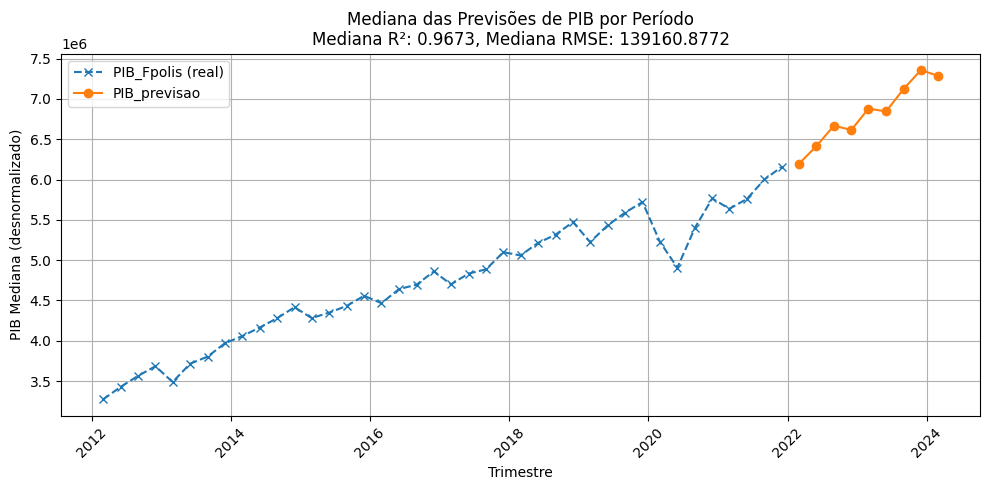

In [8]:
# Treinar modelo para cada valor de random_state de 1 a 100 e trazer mediana

# DataFrame para armazenar todas as previsões
todas_previsoes = pd.DataFrame()
resultados_metricas = []  # Lista para armazenar R2 e RMSE de cada modelo

# Loop para diferentes valores de random_state
for random_state in range(1, 101):
    # Treine o modelo de MLPRegressor com o random_state atual
    model = MLPRegressor(
        activation='relu',
        hidden_layer_sizes=(50,),
        max_iter=500,
        solver='adam',
        random_state=random_state,
        alpha=0.001
    )
    model.fit(X_normalizado_treino, y_normalizado_treino_1d)

    # Previsão e desnormalização
    y_predicao = model.predict(X_normalizado_predicao)
    y_treino_pred = model.predict(X_normalizado_treino)

    # Desnormalizar previsões
    mean_pib = df['PIB_Fpolis_IBGE_5938'].mean()
    std_pib = df['PIB_Fpolis_IBGE_5938'].std()
    pib_desnormalizado = mean_pib + (y_predicao * std_pib)
    y_treino_real = mean_pib + (y_normalizado_treino_1d * std_pib)
    y_treino_pred_desnormalizado = mean_pib + (y_treino_pred * std_pib)

    # Calcular R2 e RMSE
    r2 = r2_score(y_treino_real, y_treino_pred_desnormalizado)
    rmse = root_mean_squared_error(y_treino_real, y_treino_pred_desnormalizado)

    # Armazenar os resultados
    resultados_metricas.append({"random_state": random_state, "R2": r2, "RMSE": rmse})

    # Criar DataFrame com as previsões do random_state atual
    previsoes = pd.DataFrame({
        "Trimestre": X_normalizado_predicao.index,  # Datas dos trimestres
        "PIB_previsao": pib_desnormalizado,
        "random_state": random_state
    })

    # Concatenar com o DataFrame principal
    todas_previsoes = pd.concat([todas_previsoes, previsoes], ignore_index=True)

# Calcular a mediana para cada período
mediana_previsoes = todas_previsoes.groupby("Trimestre")["PIB_previsao"].median().reset_index()

# Calcular as medianas de R2 e RMSE
df_metricas = pd.DataFrame(resultados_metricas)
mediana_r2 = df_metricas["R2"].median()
mediana_rmse = df_metricas["RMSE"].median()

# Exibir os resultados das medianas
print("Mediana das previsões por período:")
mediana_previsoes["PIB_previsao"] = mediana_previsoes["PIB_previsao"].round(2)
print(mediana_previsoes)
print("\nMediana do R2: {:.4f}".format(mediana_r2))
print("Mediana do RMSE: {:.4f}".format(mediana_rmse))

# Plotar os resultados
plt.figure(figsize=(10, 5))
plt.plot(y.index, y, label='PIB_Fpolis (real)', linestyle='--', marker='x')
plt.plot(mediana_previsoes["Trimestre"], mediana_previsoes["PIB_previsao"], marker='o', linestyle='-', label="PIB_previsao")
plt.title("Mediana das Previsões de PIB por Período\nMediana R²: {:.4f}, Mediana RMSE: {:.4f}".format(mediana_r2, mediana_rmse))
plt.xlabel("Trimestre")
plt.ylabel("PIB Mediana (desnormalizado)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PIB deflacionado (preços constantes de março de 2024):
    Trimestre  PIB_deflacionado
0  2021-03-01        6979820.07
1  2021-06-01        6973109.84
2  2021-09-01        7106740.60
3  2021-12-01        7067215.32
4  2022-03-01        6905355.41
5  2022-06-01        7046622.36
6  2022-09-01        7402676.51
7  2022-12-01        7254895.87
8  2023-03-01        7387430.53
9  2023-06-01        7281247.79
10 2023-09-01        7499241.10
11 2023-12-01        7667600.80
12 2024-03-01        7459112.31


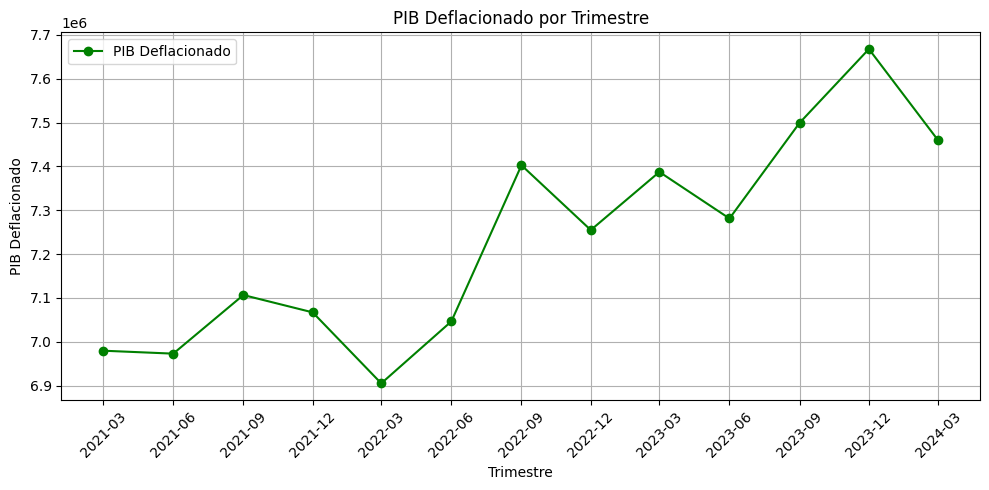

In [15]:
# Dados de inflação
dados_inflacao = pd.DataFrame({
    "Data": [
        "2021-03-01", "2021-06-01", "2021-09-01", "2021-12-01",
        "2022-03-01", "2022-06-01", "2022-09-01", "2022-12-01",
        "2023-03-01", "2023-06-01", "2023-09-01", "2023-12-01",
        "2024-03-01", "2024-06-01", "2024-09-01"
    ],
    "Indice_Inflacao": [659, 674, 689, 711,
                        732, 743, 735, 744,
                        760, 767, 775, 783,
                        797, 806, 816]
})

dados_inflacao["Data"] = pd.to_datetime(dados_inflacao["Data"])

# Dados de previsão do PIB
previsoes = pd.DataFrame({
    "Trimestre": ["2021-03-01", "2021-06-01", "2021-09-01", "2021-12-01",
                  "2022-03-01", "2022-06-01", "2022-09-01", "2022-12-01",
                  "2023-03-01", "2023-06-01", "2023-09-01", "2023-12-01",
                  "2024-03-01"
    ],

    "PIB_previsao":[5636889, 5759652, 6000667, 6157831,
                    6194510, 6416226, 6667852, 6614758,
                    6880450, 6844016, 7122441, 7357514,
                    7285432
    ]
})

previsoes["Trimestre"] = pd.to_datetime(previsoes["Trimestre"])

# Índice de referência (o mais recente, março de 2024)
indice_referencia = dados_inflacao.loc[dados_inflacao["Data"] == "2024-09-01", "Indice_Inflacao"].values[0]

# Merge dos dados de inflação e previsões
dados_completos = pd.merge(previsoes, dados_inflacao, left_on="Trimestre", right_on="Data")

# Calcular os valores deflacionados
dados_completos["PIB_deflacionado"] = (
    dados_completos["PIB_previsao"] * indice_referencia / dados_completos["Indice_Inflacao"]
)

# Selecionar colunas relevantes para o resultado final
resultado_deflacionado = dados_completos[["Trimestre", "PIB_deflacionado"]].copy()

# Exibir os resultados
resultado_deflacionado["PIB_deflacionado"] = resultado_deflacionado["PIB_deflacionado"].round(2)
print("PIB deflacionado (preços constantes de março de 2024):")
print(resultado_deflacionado)

# Plotar os resultados (opcional)
plt.figure(figsize=(10, 5))
plt.plot(resultado_deflacionado["Trimestre"], resultado_deflacionado["PIB_deflacionado"], marker="o", linestyle="-", color="green", label="PIB Deflacionado")
plt.title("PIB Deflacionado por Trimestre")
plt.xlabel("Trimestre")
plt.ylabel("PIB Deflacionado")
plt.grid(True)
plt.xticks(
    resultado_deflacionado["Trimestre"],  # Valores do eixo X
    labels=resultado_deflacionado["Trimestre"].dt.strftime('%Y-%m'),  # Formatar para "YYYY-MM"
    rotation=45)  # Rotação para melhor visualização
plt.legend()
plt.tight_layout()
plt.show()
